In [ ]:
!git clone https://github.com/Im-JihyunKim/2024_LGE_DNNCNN.git # colab 사용 시
%cd /content/2024_LGE_DNNCNN # Local PC로 실습하는 경우 실행 x / 단 작업경로를 2024_LGE_DNNCNN으로 맞춰주기

In [1]:
# !pip install IPython
from IPython.display import Image

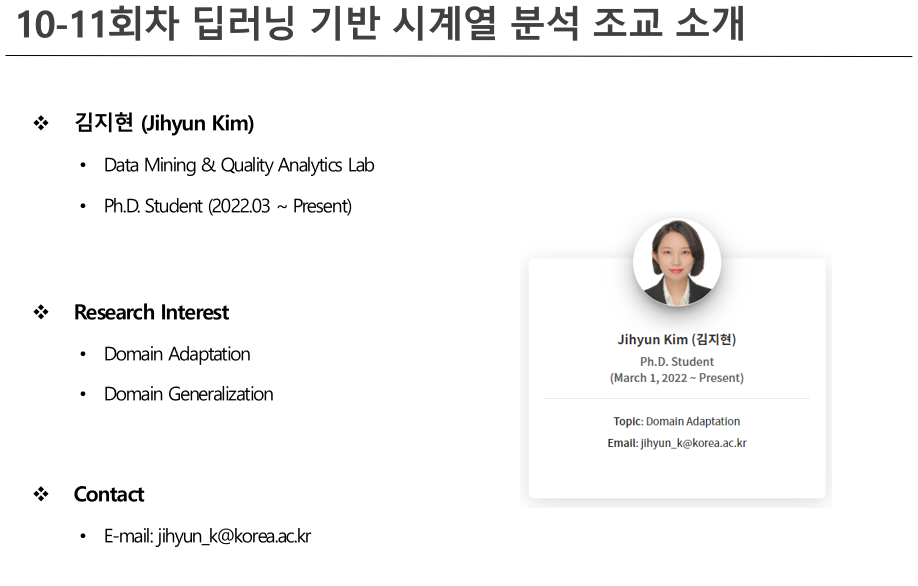

In [2]:
Image('images/img0.PNG')

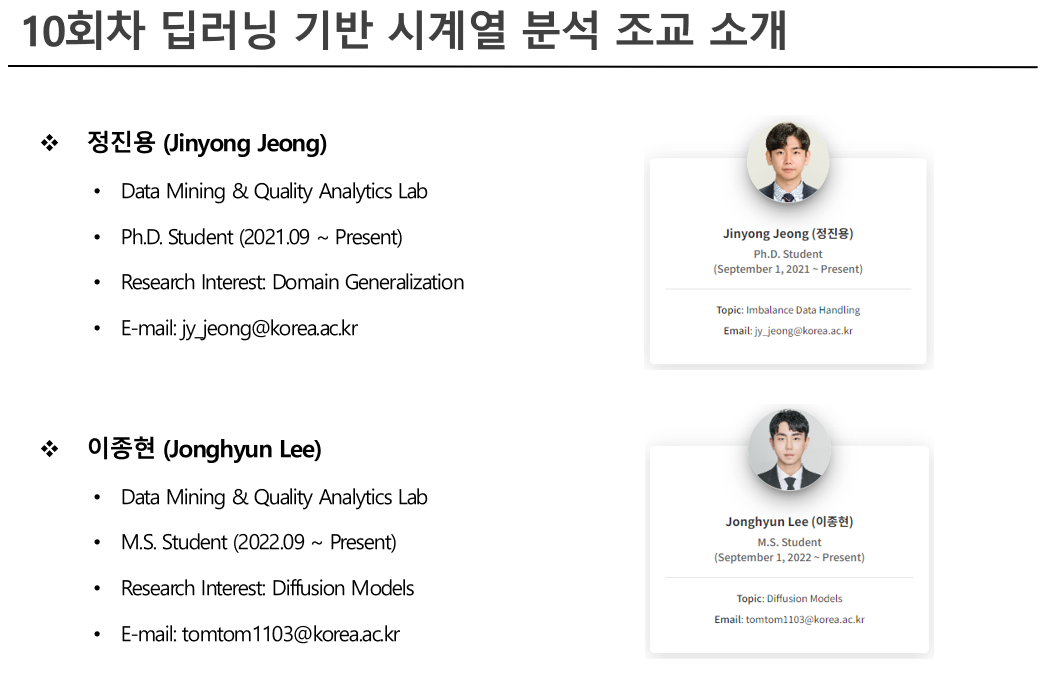

In [3]:
Image('images/img00.PNG')

## 1. PyTorch로 모델 구현: torch.nn
- The basic cuilding blocks for graphs

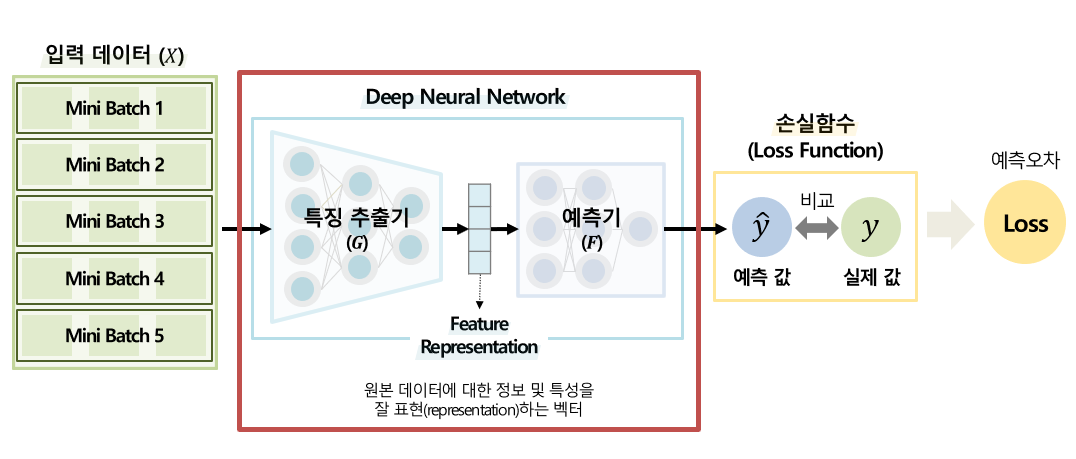

In [9]:
Image('./images/model.PNG')

### Linear layer

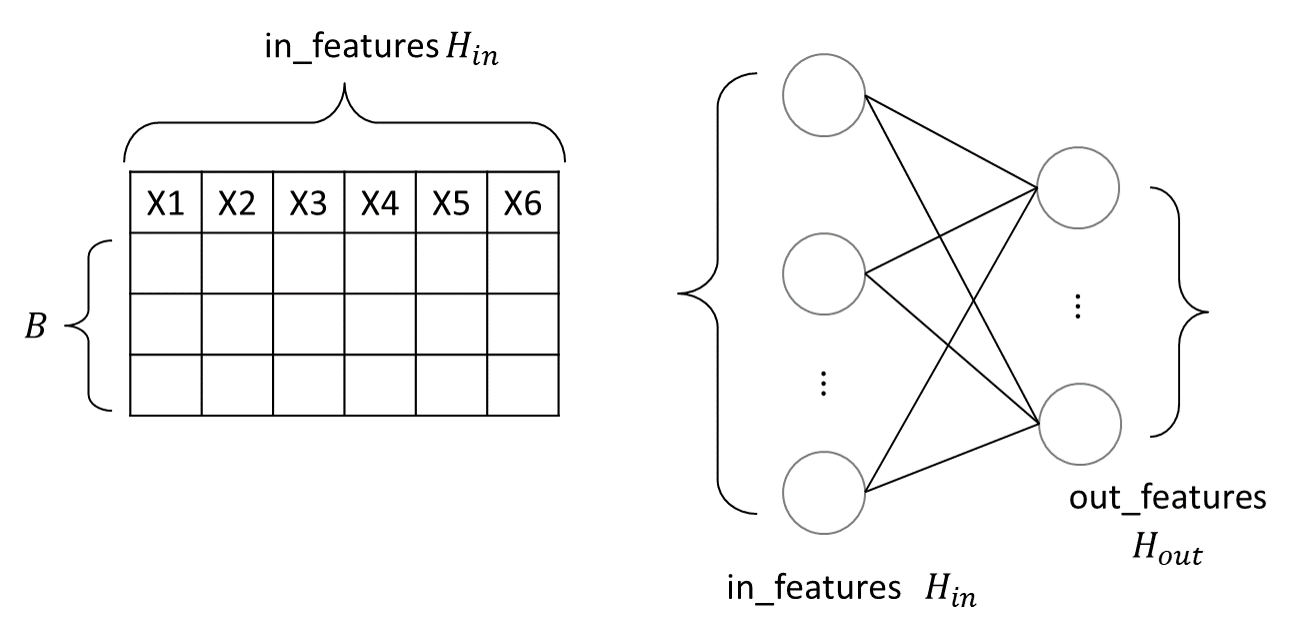

In [3]:
# linear layer
Image('./images/img1.png')

In [2]:
import torch
import torch.nn as nn
import numpy as np
from PIL import Image as Img
# !pip install torchsummary
from torchsummary import summary
import warnings
warnings.filterwarnings(action='ignore')

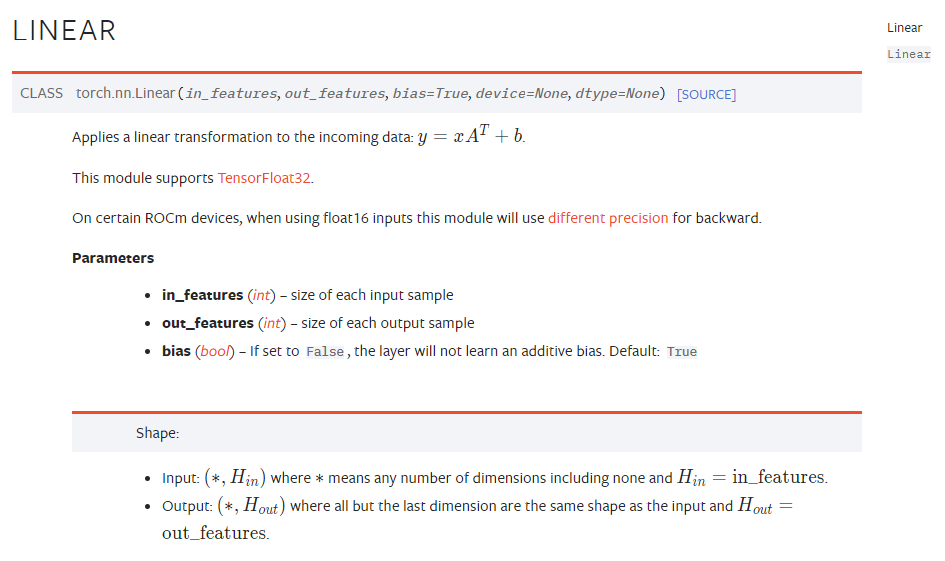

- in_features: 입력 데이터(텐서)의 크기. 데이터 차원 내지는 변수 개수
- out_features: 출력 데이터(텐서)의 크기.
- bias를 더할 것인지 말 것인지를 True/False로 구분
    - Linear를 통해 선형 변환을 수행할 때, 각 출력 특성에 추가적인 상수 항(bias)을 더해 최종 결과를 조정할지 말지 결정
    - $y=Wx+b$ 에서 b를 더할지 더하지 않을지 결정  

- 기본적으로 nn.Linear는 입력 텐서와 가중치 행렬(weight matrix) 간 행렬곱을 수행하고, 편향(bias)을 더하는 연산으로 이루어짐

In [3]:
# linear layer
x = torch.randn(32, 10) # B, H_in

linear_layer = nn.Linear(in_features=10, out_features=1)   #입력 텐서의 크기가 10이고 출력 텐서 크기가 1인 선형 변환을 수행하는 nn.Linear 모듈 생성
print(linear_layer(x).shape) # B, H_out

torch.Size([32, 1])


### Convolution Layer

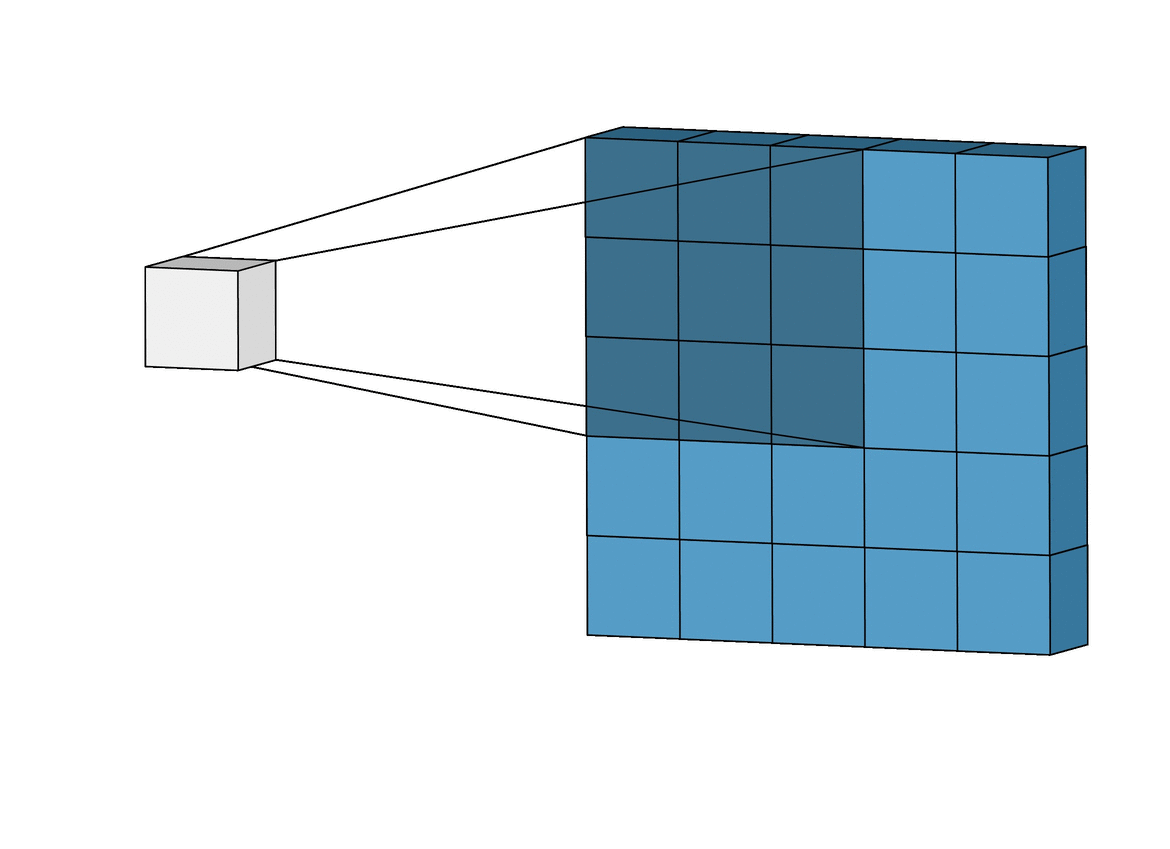

In [6]:
Image('./images/Conv1.gif')

#### CNN의 초기 레이어
- 입력 데이터의 가장 기본적인 정보(edge, colors) 등 저수준(low-level) 특성을 추출하여 데이터의 기본적인 구조를 이해
- 이미지 데이터라면 전반적인 style과 관련한 국소적 특징을 잡아낼 수 있음

#### CNN의 후반부 레이어
- 고수준(high-level) 특성을 추출하여 객체의 전체적인 형태 등을 바라볼 수 있음
- 이미지 분류문제에서, 이미지 내의 객체의 종류를 인식하고 분류하기 위한 특성 추출; 객체 식별에 필요한 복잡한 특성들이 학습됨
    - 추출되는 정보가 보다 추상적이며, 이미지를 구성하는 구체적인 객체나 장면의 의미를 파악할 수 있는 정보가 담김

#### 합성곱(Convolution) 연산 구현

1. Image와 Kernel 정의

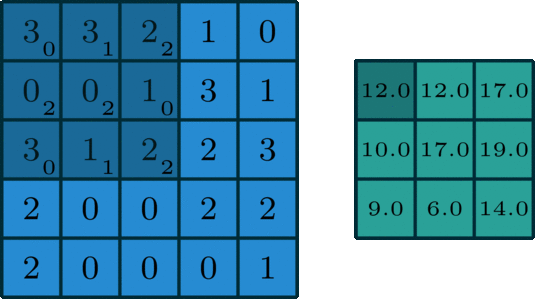

In [11]:
Image('./images/Conv2.gif')

In [3]:
image = np.array([[3,3,2,1,0],
                  [0,0,1,3,1],
                  [3,1,2,2,3],
                  [2,0,0,2,2],
                  [2,0,0,0,1]])

kernel_ = np.array([[0, 1, 2],
                    [2, 2, 0],
                    [0, 1, 2]])

print(f'Input Data (H*W): \n {image}')
print(f'Kernel (n*m): \n {kernel_}')

Input Data (H*W): 
 [[3 3 2 1 0]
 [0 0 1 3 1]
 [3 1 2 2 3]
 [2 0 0 2 2]
 [2 0 0 0 1]]
Kernel (n*m): 
 [[0 1 2]
 [2 2 0]
 [0 1 2]]


2. height * weight 크기의 이미지를 n*m 크기의 kernel 행렬로 처음부터 끝까지 겹치며 훑음  

3. 훑는 과정에서 n*m 크기의 겹쳐지는 부분의 각 이미지 픽셀 값과 kernel의 원소 값을 곱해서 모두 더한 값을 출력 -> "합성곱" 연산을 통한 원본 이미지 데이터 특징 추출    

    참고 1) kernel은 일반적으로 3x3, 5x5 크기의 행렬을 이용  
    참고 2) kernel의 원소 값은 모델 학습 과정에서 데이터로부터 자동으로 학습됨 (초기에는 무작위로 초기화 됨)  
    참고 3) stride는 kernel이 지나가는 이동 범위를 의미.

In [5]:
# Image와 Filter의 Height, width
image_h, image_w = image.shape
kernel_h, kernel_w = kernel_.shape

# 합성곱 연산
result = []
for i in range(image_h - kernel_h + 1):
    for j in range(image_w - kernel_w + 1):
        conv = (image[i:i + kernel_w, j: j + kernel_w] * kernel_).sum()
        result.append(conv)
        
# Output (feature map)
output = np.array(result).reshape(3, 3)
print(f'Output: \n {output}')  # 5x5 -> 3x3

Output: 
 [[12 12 17]
 [10 17 19]
 [ 9  6 14]]


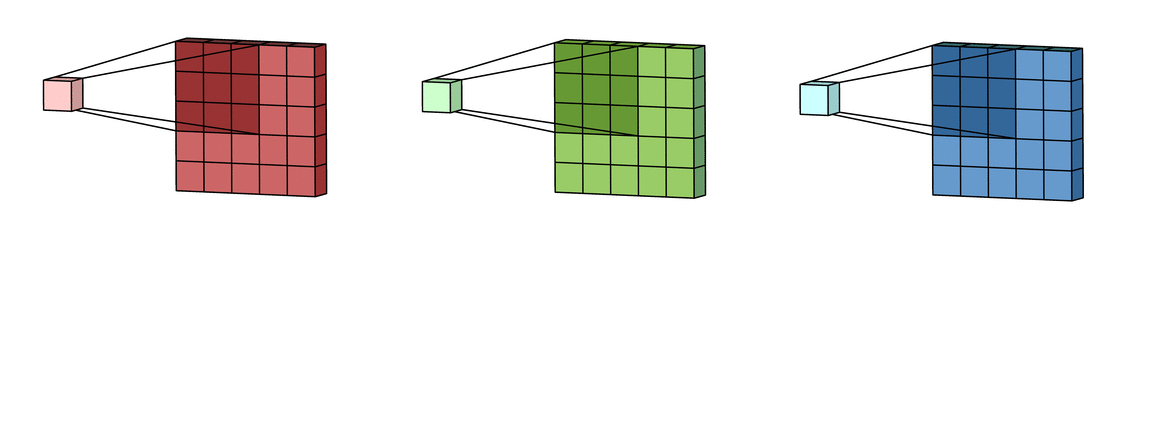

In [6]:
Image('./images/Conv3.gif')

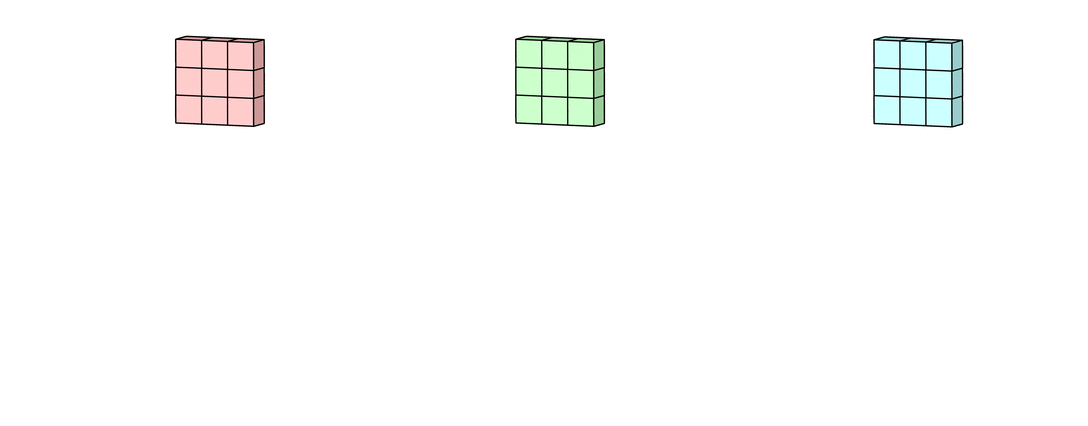

In [7]:
Image('./images/Conv4.gif')

실제로 대부분의 입력 이미지는 3개의 채널을 가짐!  
더불어 실제로 사용하는 kernel의 개수는 1개보다 많음 (복잡한 특성 추출을 위함)
- cf. 한 kernel은 각 channel 모두에 대해 합성곱 연산을 수행 후 그 결과를 합하여 최종 출력을 생성

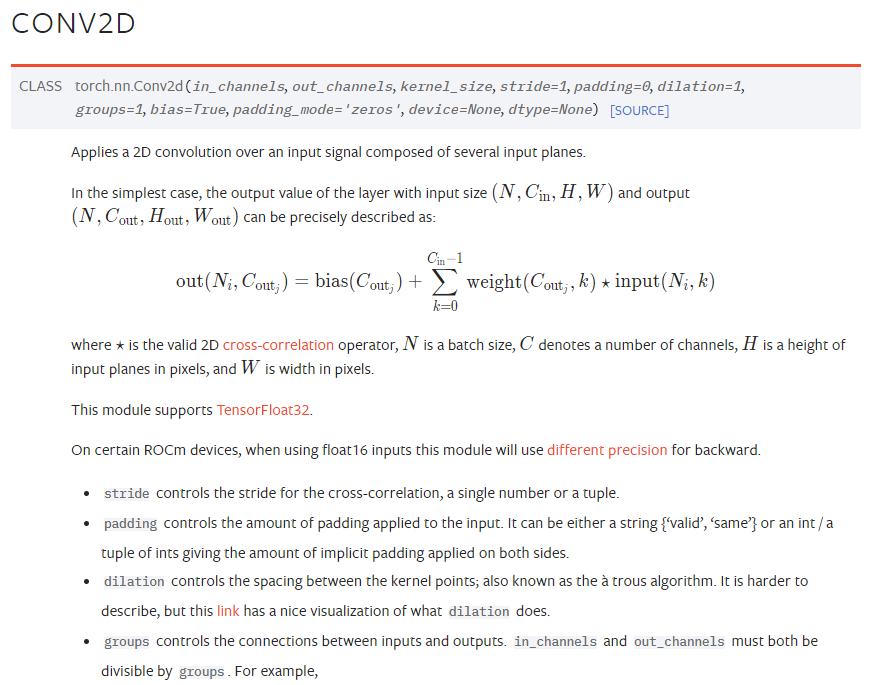

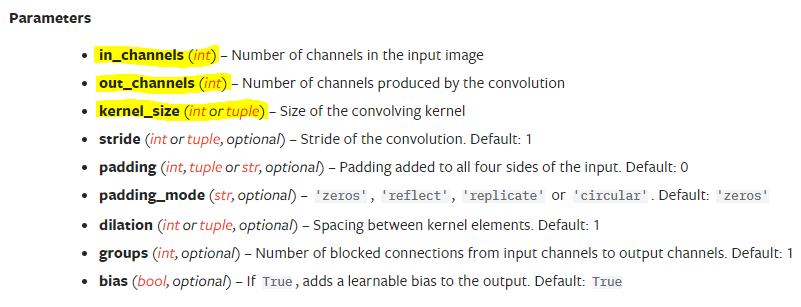

- in_channels: 입력 채널의 개수, RGB 이미지는 3.
- out_channels: 출력되는 feature map의 채널 수, 사용하려는 kernel 개수를 의미함. 값이 클 수록 더 복잡한 특징 학습이 가능하나, 모델의 파라미터 수도 증가함
- kernel_size: convolution kernel 크기. 3x3 kernel는 (3,3)으로 지정
- stride: convolution kernel 이동 간격 (기본 값 1)

#### 참고
- padding: 이미지 데이터의 경우, 가장자리 pixel 값은 kernel의 중심에 있지 않아 정보값이 손실될 여지가 있음, 더불어 입력 데이터와 출력 데이터의 크기가 동일해야 하는 경우도 있음 
    - 따라서 fake pixel 값 (일반적으로 0 - zero padding)을 가장자리를 채워서 가짜 픽셀로 입력 데이터를 확장
- dilation: 합성곱 연산에서 kernel 내의 각 요소 간 간격을 지정. kernel 내 각 element가 적용되는 간격을 조절하여 kernel이 커버하는 입력 데이터의 영역(receptive field)를 확장할 수 있음
    - 1인 경우 기본 conv와 동일하게 작동
    - 2인 경우 kernel 각 요소 사이에 하나의 간격을 두고 적용됨 (입력 데이터의 넓은 영역을 커버 가능)

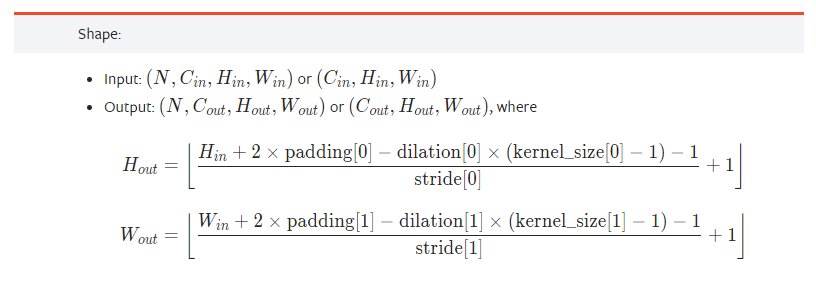

In [8]:
# convolution layer
imgs = torch.randn(32, 3, 64, 64) # B, C_in, H, W
conv_layer = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(2,2), stride=(2,2))  # layer 정의
output = conv_layer(imgs)  # 합성곱 연산 수행
print(output.shape)        # B, C_out, H_out, W_out

torch.Size([32, 16, 32, 32])


- nn.Conv2d를 이용하여 입력 데이터 크기가 (32,3,64,64)인 4D 텐서를 입력으로 받아 입력 채널을 64개의 출력 채널을 가진 feature map으로 변환하는 합성곱 연산을 수행

### 1D CNN

- 입력 데이터의 한 방향 (주로 시간 축)으로 합성곱 연산을 수행
- kernel의 width 값은 입력 데이터 차원과 동일하게 설정됨. 따라서 kernel height 값만으로 kernel size를 지정 (하나의 축으로만 합성곱 연산 수행)

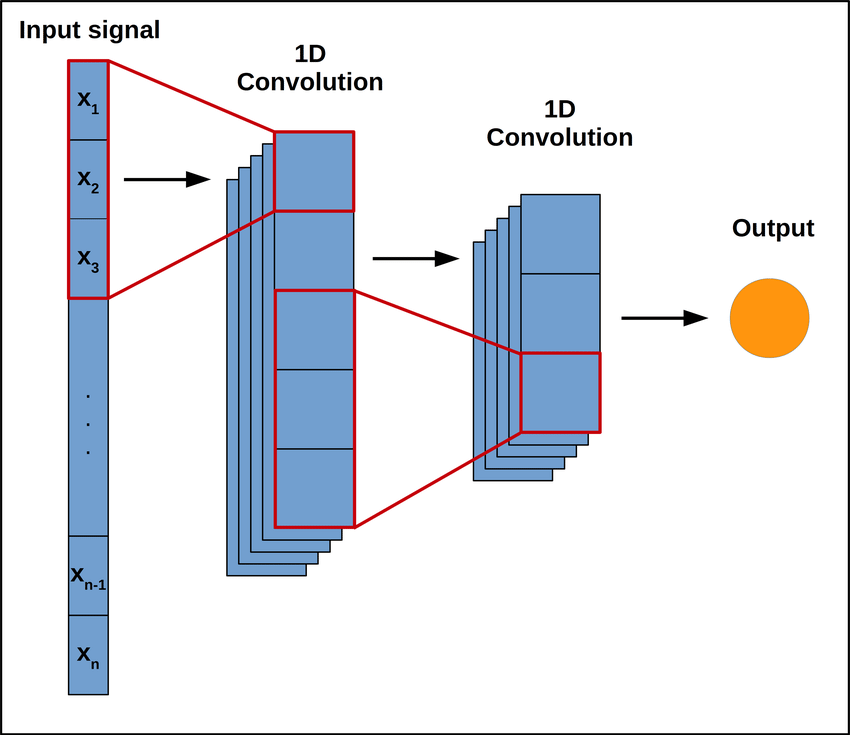

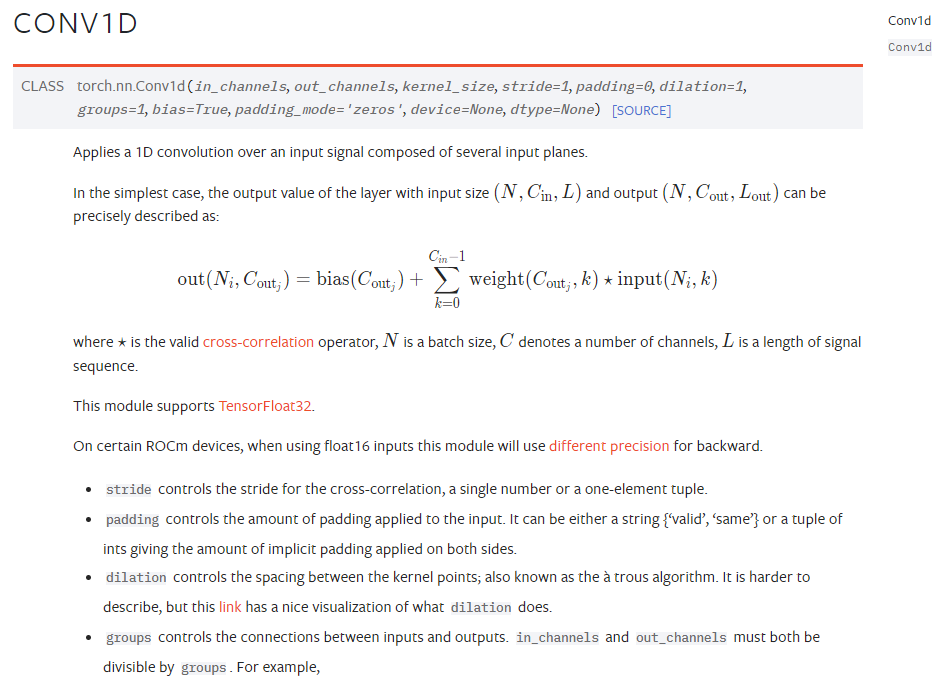

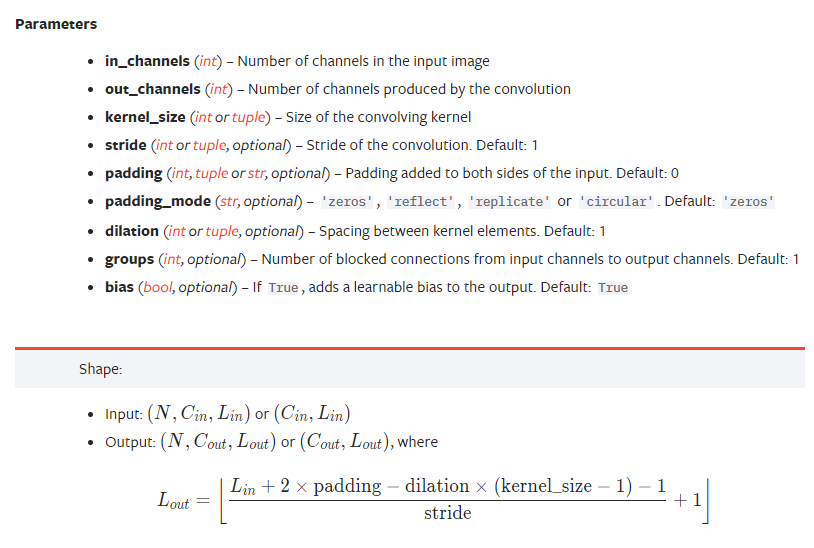

In [19]:
# convolution layer
imgs = torch.randn(32, 16, 50) # B, C_in(입력 채널 수), sequence 길이
conv1_layer = nn.Conv1d(in_channels=16, out_channels=20, kernel_size=16, stride=2)  # layer 정의
output = conv1_layer(imgs)  # 합성곱 연산 수행
print(output.shape) # B, C_out, L_out

torch.Size([32, 20, 18])


### Activation function
- `nn.Linear`는 데이터를 선형 변환 -> 비선형 함수를 통해 더 복잡한 데이터의 패턴을 학습할 수 있도록 함 (현실 세계 대부분은 비선형 문제; e.g. XOR)  

- `ReLU`: $f(x)=max(0, x)$ [0, max], 계산 효율성이 높고 기울기 소실 문제 완화 가능
- `Sigmoid`: $f(x)=1/(1+exp(-x))$ [0, 1], 출력이 확률로 해석될 수 있어 이진 분류 문제 출력층에서 자주 사용됨
- `Tanh` (Hyperbolic Tangent): $f(x)=tanh(x)=2/(1+exp(-2x))-1$ [-1, 1], Sigmoid에 비해 출력 범위가 더 넓고 중심점이 0에 가까워 학습이 더 안정적일 수 있음
- 그 외에도 `LeakyReLU` 등 다양한 활성화 함수들이 있음

In [24]:
# activation functions
x = torch.FloatTensor([[-1,1]])
relu = nn.ReLU(inplace=True)  # inplace=True: 입력 텐서를 직접 수정하여 연산 속도 향상 (기본 값은 False, 새로운 텐서 반환)
sigmoid = nn.Sigmoid()
tanh = nn.Tanh()

print(x.shape, x, relu(x))
print(x.shape, x, sigmoid(x))
print(x.shape, x, tanh(x))

torch.Size([1, 2]) tensor([[0., 1.]]) tensor([[0., 1.]])
torch.Size([1, 2]) tensor([[0., 1.]]) tensor([[0.5000, 0.7311]])
torch.Size([1, 2]) tensor([[0., 1.]]) tensor([[0.0000, 0.7616]])


### nn.Flatten()
- PyTorch Tensor를 1차원으로 평탄화(flatten) 하는 class.
- CNN 등의 레이어를 지나 나온 다차원 텐서 값을 1차원으로 변환하여, fully-connected (FC) layer, 즉 MLP 레이어에 입력으로 제공할 수 있도록 함

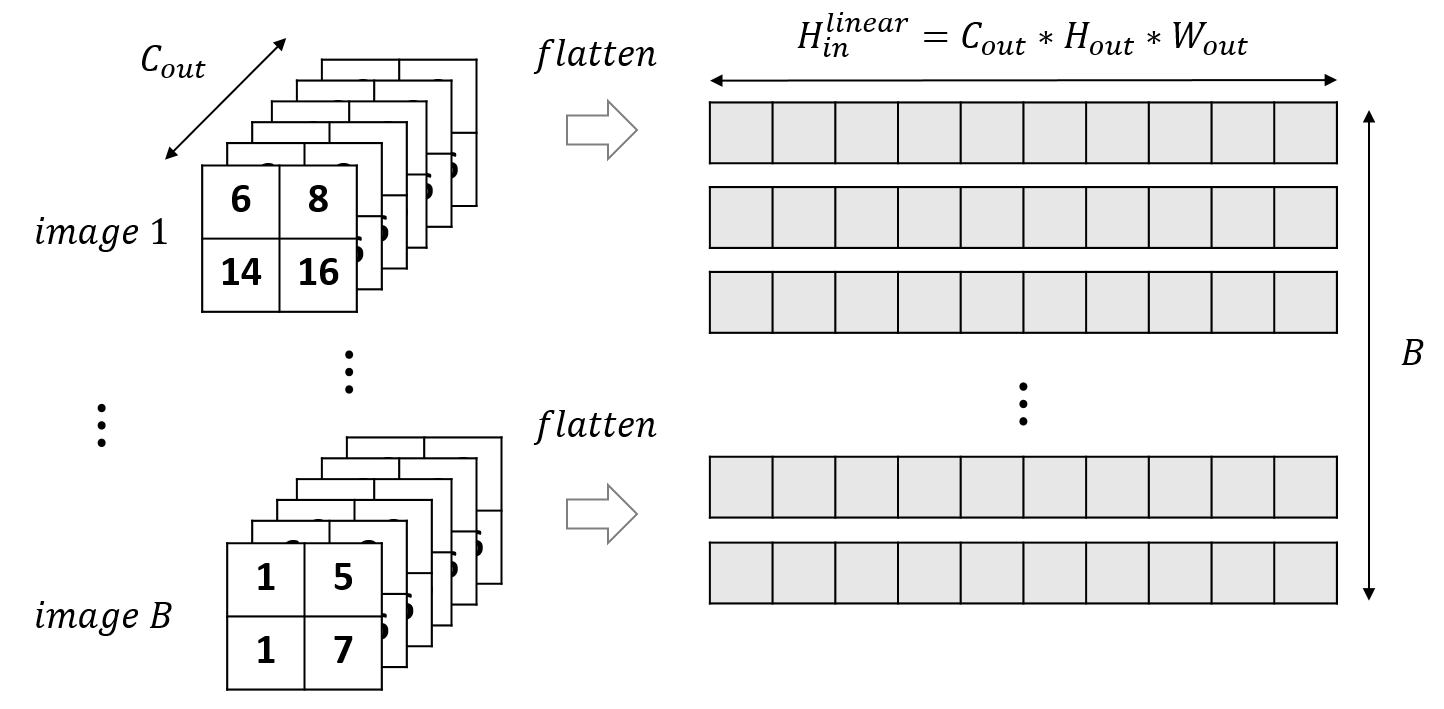

In [1]:
# flatten
Image.open('./images/img5.png')

In [11]:
x = torch.randn(32, 3, 5, 6)
flatten = nn.Flatten()
x_flatten = flatten(x)

print(x.shape, '\n', x_flatten.shape)

torch.Size([32, 3, 5, 6]) 
 torch.Size([32, 90])


In [12]:
# cf. .view, .reshape 등으로 같은 결과를 얻을 수 있음
x_reshaped = x.view(x.size(0), -1)

print(x.shape, '\n', x_reshaped.shape)

torch.Size([32, 3, 5, 6]) 
 torch.Size([32, 90])


## 참고. 모델의 과적합 (Overfitting)

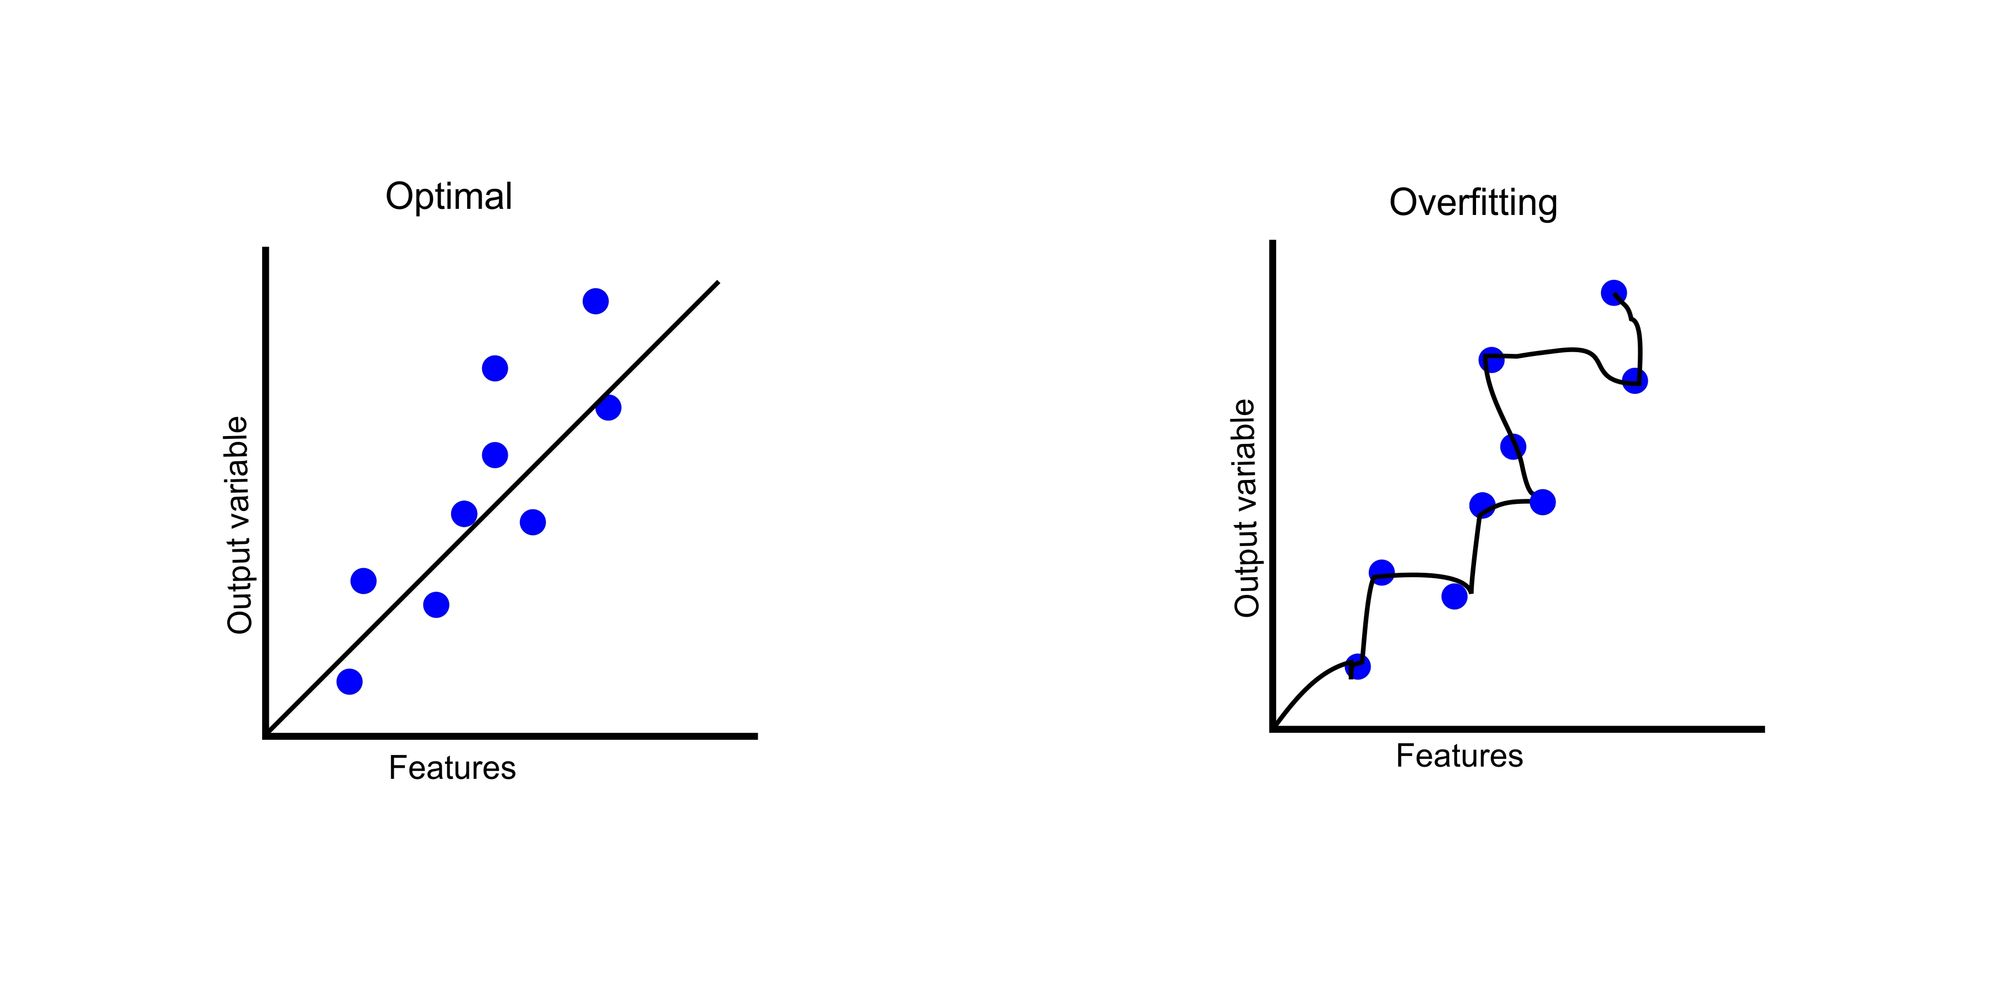

In [10]:
Image('./images/overfitting.PNG')

### Pooling
- 합성곱 연산을 수행한 뒤 도출된 feature map의 차원을 축소시키는 데 활용
    - 차원을 축소하여 연산량을 감소시키고, 모델 파라미터 수를 줄여 모델이 훈련 데이터에 과적합되는 것을 방지
    - pooling은 정보를 일부 손실시키는 것이기에, pooling을 통해 얻은 특징은 입력 데이터의 작은 변화나 왜곡에 강인해짐
- Max Pooling: feature map의 특정 영역에서 최대 값을 택하여 새로운 feature map 생성. 가장 두드러지는 특징 값을 유지 가능
- Average Pooling: feature map의 특정 영역에서 평균 값을 계산하여 새로운 feature map 생성. 영역 내 모든 값들을 고려 가능
- 합성곱 연산과 활성화 함수를 지난 뒤에 pooling 수행

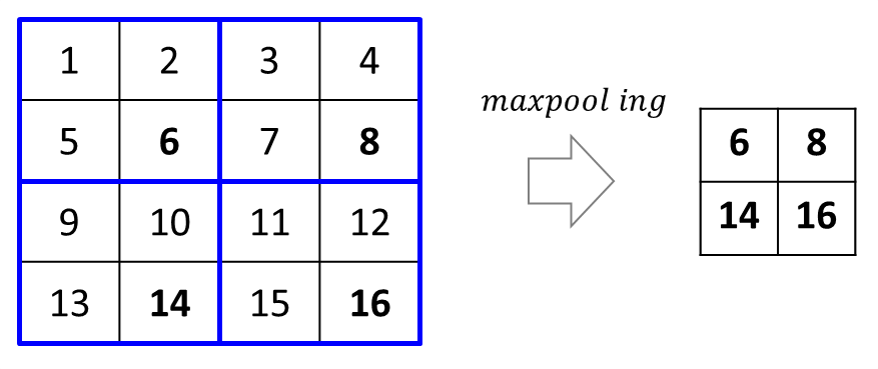

In [25]:
# pooling layer : pooling layer는 parameter(weight)가 필요없기 때문에 통해서 H,W의 크기를 효율적으로 줄일 수 있음
Image.open('./images/img3.png')

In [26]:
# 1D-pooling layer
x = torch.FloatTensor([[-1,1,2,6]])
maxpool = nn.MaxPool1d(kernel_size=2,stride=2)
avgpool = nn.AvgPool1d(kernel_size=2,stride=2)
print(x, maxpool(x), avgpool(x))

tensor([[-1.,  1.,  2.,  6.]]) tensor([[1., 6.]]) tensor([[0., 4.]])


In [27]:
# 2D-pooling layer
imgs = torch.randint(0,5,size=(1,1,4,4)).float()
maxpool = nn.MaxPool2d(kernel_size=(2,2),stride=(2,2))
avgpool = nn.AvgPool2d(kernel_size=(2,2),stride=(2,2))
print('원본 텐서','\n',imgs,'\n')
print('maxpooling :','\n',maxpool(imgs),'\n')
print('avgpooling :','\n',avgpool(imgs),'\n')

원본 텐서 
 tensor([[[[4., 2., 3., 3.],
          [4., 2., 2., 4.],
          [0., 1., 2., 0.],
          [3., 1., 0., 4.]]]]) 

maxpooling : 
 tensor([[[[4., 4.],
          [3., 4.]]]]) 

avgpooling : 
 tensor([[[[3.0000, 3.0000],
          [1.2500, 1.5000]]]]) 



### BatchNorm
- 학습 과정에서 네트워크의 파라미터가 변함에 따라서, 레이어 별로 입력 값의 분포가 계속 변하는 현상을 방지
- 따라서 각 Batch 내 데이터의 평균과 분산을 이용하여 데이터 정규화 (평균 0, 분산 1이 되도록) -> 레이어 입력의 분포를 일정하게 유지 가능

In [30]:
# batchnorm 1D
x = torch.FloatTensor([[1,2,3,4],
                       [2,2,2,2],
                       [3,2,1,1]])

batchnorm = nn.BatchNorm1d(num_features=4)  # num_features -> 입력 데이터의 채널 수
print(x, '\n', batchnorm(x))

tensor([[1., 2., 3., 4.],
        [2., 2., 2., 2.],
        [3., 2., 1., 1.]]) 
 tensor([[-1.2247,  0.0000,  1.2247,  1.3363],
        [ 0.0000,  0.0000,  0.0000, -0.2673],
        [ 1.2247,  0.0000, -1.2247, -1.0690]],
       grad_fn=<NativeBatchNormBackward0>)


이미지 데이터의 경우, Batch Normalization은 channel 별로 계산됨

In [39]:
# batchnorm 2D
imgs = torch.randint(0,5,size=(1,3,4,4)).float()
batchnorm = nn.BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
print(imgs, '\n', batchnorm(imgs))

tensor([[[[3., 3., 0., 3.],
          [2., 0., 3., 0.],
          [2., 2., 0., 4.],
          [0., 2., 2., 4.]],

         [[2., 0., 1., 2.],
          [1., 2., 2., 0.],
          [3., 0., 0., 4.],
          [1., 0., 3., 3.]],

         [[3., 3., 1., 0.],
          [3., 4., 0., 1.],
          [2., 3., 1., 2.],
          [2., 4., 0., 0.]]]]) 
 tensor([[[[ 0.7986,  0.7986, -1.3310,  0.7986],
          [ 0.0887, -1.3310,  0.7986, -1.3310],
          [ 0.0887,  0.0887, -1.3310,  1.5085],
          [-1.3310,  0.0887,  0.0887,  1.5085]],

         [[ 0.3922, -1.1767, -0.3922,  0.3922],
          [-0.3922,  0.3922,  0.3922, -1.1767],
          [ 1.1767, -1.1767, -1.1767,  1.9612],
          [-0.3922, -1.1767,  1.1767,  1.1767]],

         [[ 0.8610,  0.8610, -0.5891, -1.3141],
          [ 0.8610,  1.5860, -1.3141, -0.5891],
          [ 0.1359,  0.8610, -0.5891,  0.1359],
          [ 0.1359,  1.5860, -1.3141, -1.3141]]]],
       grad_fn=<NativeBatchNormBackward0>)


### Dropout
- 과적합 방지를 위해 학습 과정 중 뉴런의 일부를 무작위로 선택하여(p의 비율만큼 뉴런을 선택) 뉴런 출력을 0으로 설정하는 기법
- 즉, 무작위로 뉴런을 제거하여 네트워크가 특정 뉴런이나 뉴런 조합에 의존하는 것을 방지하고, 입력 데이터의 표현을 좀 더 다양하게 볼 수 있도록 함 (실제 데이터의 다양한 변동성에 더 잘 대응할 수 있도록)
- 학습에만 적용하고, Test 시에는 적용되지 않음

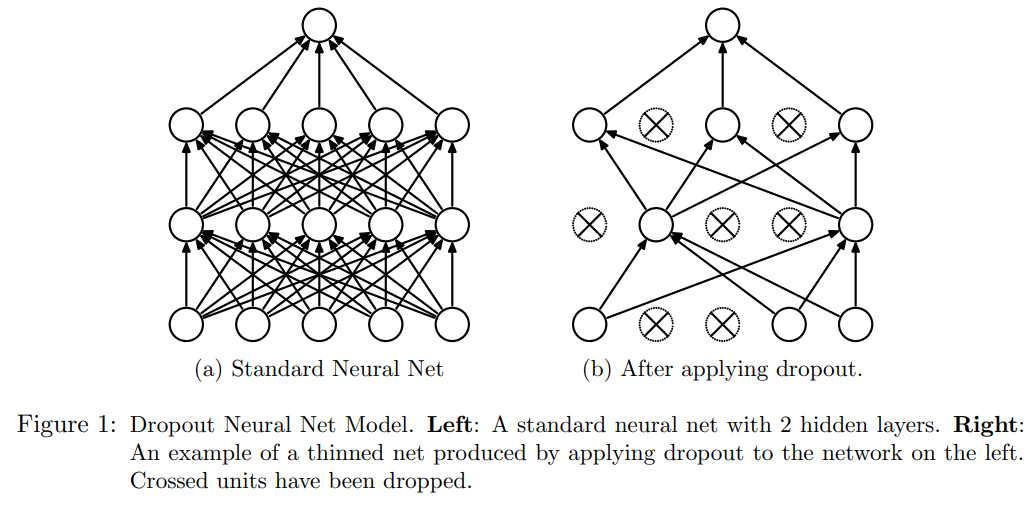

In [11]:
Image('./images/dropout.PNG')

In [7]:
x = torch.FloatTensor([[1,2,3],
                       [2,2,2],
                       [3,2,1]])
dropout = nn.Dropout(p=0.5)   # randomly zeroes some of the elements of the input tensor with prob. `p`
print(x, '\n', dropout(x))  # the outputs are scaled by a factor of `1/(1-p)` during training
                            # This means that during evaluation the module simply computes an identity function.

tensor([[1., 2., 3.],
        [2., 2., 2.],
        [3., 2., 1.]]) 
 tensor([[2., 4., 6.],
        [0., 4., 4.],
        [0., 0., 0.]])


- 입력 값이 1/0.5 가 곱해진 형태로 출력되는 것을 알 수 있음 (랜덤하게 선택된 다른 값은 0)
- 스케일링의 이유는 활성 뉴런이 줄어든 것을 보상하기 위함 (학습과 추론 단계에서 출력 기댓값을 일관되게 유지하기 위함)

## 신경망 모델 구성하기
### nn.Sequential
- 순서를 가지는 컨테이너. 정의된 모듈들을 순차적으로 사용하여 입력 데이터를 전달

In [9]:
x = torch.randn(64,3,64,64)

conv_block = nn.Sequential(nn.Conv2d(in_channels=3,out_channels=16,kernel_size=(3,3),stride=(1,1),padding=(1,1)),
                           nn.BatchNorm2d(num_features=16),
                           nn.ReLU(inplace=True),
                           nn.Dropout(p=0.1),
                           nn.MaxPool2d(kernel_size=(3,3),stride=(2,2), padding=(1,1))
)

summary(model=conv_block, input_size=(3,64,64), device='cpu')
print(conv_block(x).shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 64, 64]             448
       BatchNorm2d-2           [-1, 16, 64, 64]              32
              ReLU-3           [-1, 16, 64, 64]               0
           Dropout-4           [-1, 16, 64, 64]               0
         MaxPool2d-5           [-1, 16, 32, 32]               0
Total params: 480
Trainable params: 480
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 2.12
Params size (MB): 0.00
Estimated Total Size (MB): 2.17
----------------------------------------------------------------
torch.Size([64, 16, 32, 32])


### nn.Module
- PyTorch의 모든 모듈은 nn.Module의 하위 class.
- nn.Module을 상속받은 모든 class는 `forward` 메소드(함수)에 입력 데이터에 대한 연산들을 구현함

In [ ]:
"""
class CustomModel(torch.nn.Module):
  def __init__(self):
  원하는 nueral networks 모델 구조를 layer 별로 혹은 block화 하여 정의

  def forward(self, x):
  __init__에서 정의한 nueral networks에 모델을 입력하여 예측값을 얻는 forward 과정
  nn.Module을 상속받아 모델 class를 정의한 후 forward 메소드를 실행할 때에는, forward를 명시적으로 써주지 않아도 자동 실행 가능
"""

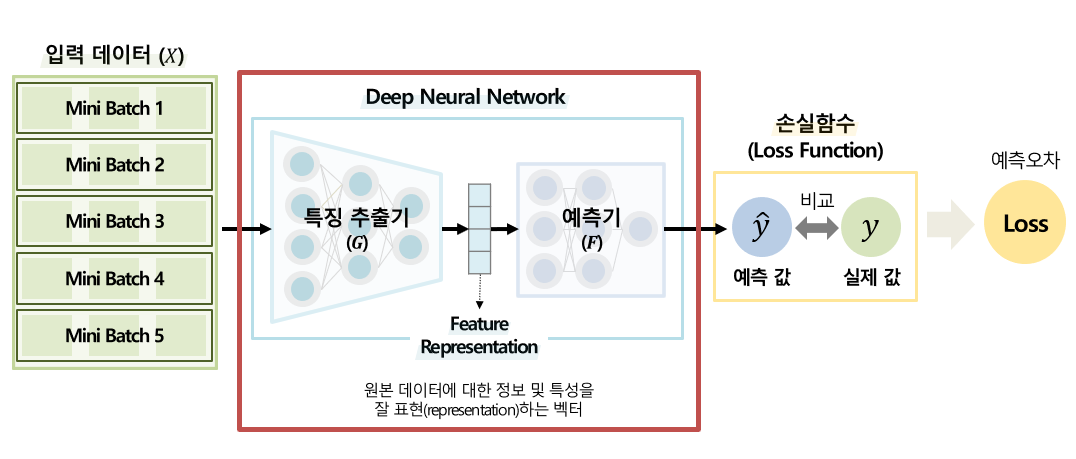

In [12]:
Image('./images/model.PNG')

In [ ]:
class MyNetwork(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.feature_extractor_G = nn.Sequential(nn.Conv2d(in_channels=3,out_channels=6,kernel_size=(5,5),stride=(1,1),padding=(0,0)), 
                           nn.BatchNorm2d(num_features=6),
                           nn.Tanh(),
                           nn.Dropout(p=0.1),
                           nn.AvgPool2d(kernel_size=(2,2),stride=(2,2), padding=(0,0)),
                           
                           nn.Conv2d(in_channels=6,out_channels=16,kernel_size=(5,5),stride=(1,1),padding=(0,0)), 
                           nn.BatchNorm2d(num_features=16),
                           nn.Tanh(),
                           nn.Dropout(p=0.1),
                           nn.AvgPool2d(kernel_size=(2,2),stride=(2,2), padding=(0,0)),
                           
                           nn.Conv2d(in_channels=16,out_channels=120,kernel_size=(5,5),stride=(1,1),padding=(0,0)), 
                           nn.Tanh())
        
        self.flatten = nn.Flatten(start_dim=1, end_dim=-1)

        self.predictor_F = nn.Sequential(nn.Linear(120,84),
                                        nn.Tanh(),
                                        nn.Linear(84,num_classes))
        
        self.init_weights()
        
    def forward(self, x):
        # x : B, 3, 32, 32
        representation = self.feature_extractor_G(x)
        representation_flatten = self.flatten(representation)
        pred = self.predictor_F(representation_flatten) # pred -> B, num_classes
        return pred
    
    # 모델의 파라미터를 초기화
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight,
                                        mode='fan_out',
                                        nonlinearity='leaky_relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1.0)
                nn.init.constant_(m.bias, 0.0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0.0)

In [ ]:
summary(MyNetwork(num_classes=10), input_size=(3,32,32), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
       BatchNorm2d-2            [-1, 6, 28, 28]              12
              Tanh-3            [-1, 6, 28, 28]               0
           Dropout-4            [-1, 6, 28, 28]               0
         AvgPool2d-5            [-1, 6, 14, 14]               0
            Conv2d-6           [-1, 16, 10, 10]           2,416
       BatchNorm2d-7           [-1, 16, 10, 10]              32
              Tanh-8           [-1, 16, 10, 10]               0
           Dropout-9           [-1, 16, 10, 10]               0
        AvgPool2d-10             [-1, 16, 5, 5]               0
           Conv2d-11            [-1, 120, 1, 1]          48,120
             Tanh-12            [-1, 120, 1, 1]               0
          Flatten-13                  [-1, 120]               0
           Linear-14                   

In [ ]:
x = torch.randn(size=(64,3,32,32))
model = MyNetwork(num_classes=10)

print(x.shape, model(x).shape)

torch.Size([64, 3, 32, 32]) torch.Size([64, 10])


In [ ]:
x = torch.randn(size=(64,3,32,32))
model = MyNetwork(num_classes=10)

print(x.shape, model(x).shape)

torch.Size([64, 3, 32, 32]) torch.Size([64, 10])


### Save and Load Parameters of Model

In [ ]:
import os  # 경로 접근에 유용한 라이브러리ㄴ

# save model parameters / torch는 모델 구조 자체를 저장하는 것이 아니고 parameter만 저장
save_dir = './results/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# dictionary로 모델의 parameter뿐만 아니라 다른 정보들(ex. best epoch, best accuracy 등)을 저장
save_dict = {'model_G':model.feature_extractor_G.state_dict(),
             'model_F':model.predictor_F.state_dict(),
             
             'model':model.state_dict()
             }

torch.save(save_dict, os.path.join(save_dir, 'model_checkpoint.pt'))

In [ ]:
os.path.join(save_dir, 'model_checkpoint.pt')   # directory 접근 및 생성에 유용

'./results/model_checkpoint.pt'

In [ ]:
# load model parameters / 모델 구조를 불러온 뒤 parameter를 해당 레이어로 load해줘야함
model = MyNetwork(num_classes=10) # 모델 구조 선언

load_dict = torch.load(os.path.join(save_dir, 'model_checkpoint.pt'), map_location='cpu')   # 딕셔너리 형태로 저장된 모델의 체크포인트 불러오기
parameters = load_dict['model']    # 'model_G', 'model_F', 'model' 중 'model'의 파라미터를 불러오기
model.load_state_dict(parameters, strict=False)

<All keys matched successfully>

In [ ]:
model = MyNetwork(num_classes=10) # 모델 구조 선언
G = model.feature_extractor_G
G.load_state_dict(torch.load(os.path.join(save_dir, 'model_checkpoint.pt'), map_location='cpu')['model_G'])   # 모델의 일부분만 파라미터 업데이트

<All keys matched successfully>

### Layer Block화
- 모델의 특정 부분에 대한 수정이 쉽고 변경 사항 유지보수가 수월

In [ ]:
class MyNetwork2(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.G_block1 = nn.Sequential(nn.Conv2d(in_channels=3,out_channels=6,kernel_size=(5,5),stride=(1,1),padding=(0,0)), 
                           nn.BatchNorm2d(num_features=6),
                           nn.Tanh(),
                           nn.Dropout(p=0.1),
                           nn.AvgPool2d(kernel_size=(2,2),stride=(2,2), padding=(0,0)))
                           
        self.G_block2 = nn.Sequential(nn.Conv2d(in_channels=6,out_channels=16,kernel_size=(5,5),stride=(1,1),padding=(0,0)), 
                           nn.BatchNorm2d(num_features=16),
                           nn.Tanh(),
                           nn.Dropout(p=0.1),
                           nn.AvgPool2d(kernel_size=(2,2),stride=(2,2), padding=(0,0)))
                           
        self.G_block3 = nn.Sequential(nn.Conv2d(in_channels=16,out_channels=120,kernel_size=(5,5),stride=(1,1),padding=(0,0)), 
                           nn.Tanh())
        
        self.flatten = nn.Flatten(start_dim=1, end_dim=-1)

        self.predictor_F = nn.Sequential(nn.Linear(120,84),
                                        nn.Tanh(),
                                        nn.Linear(84,num_classes))
        
        self.init_weights()
        
    def forward(self, x):
        # x : B, 3, 32, 32
        representation1 = self.G_block1(x)  # B, 6, 14, 14 
        representation2 = self.G_block2(representation1)  # B, 16, 5, 5
        final_representation = self.G_block3(representation2)  # B, 120, 1, 1

        representation_flatten = self.flatten(final_representation)  # B, 120*1*1
        pred = self.predictor_F(representation_flatten) # pred -> B, num_classes
        return pred
    
    # 모델의 파라미터를 초기화
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight,
                                        mode='fan_out',
                                        nonlinearity='leaky_relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1.0)
                nn.init.constant_(m.bias, 0.0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0.0)